In [1]:
import os
os.chdir('../')

## Analysis improvement error: heuristic vs. optimized

In [2]:
from utils import *
from loader import *

logging.disable(logging.CRITICAL)

from PCAfold import compute_normalized_variance, cost_function_normalized_variance_derivative, KReg
import numpy as np
import matplotlib.pyplot as plt
import sys
import matplotlib.ticker as ticker
import matplotlib.patches as patches
from matplotlib.ticker import LogLocator
import matplotlib.cm as cm

# Supplementary material: origin and comparison of the MSE error for the full state-space models parametrized by the heuristic and optimized PV

In [3]:
data_path = "data-files/MSE_NN/"

In [4]:
allObs_heu = np.load(data_path + "MSE_allObs_QoIs_val_NN_heuristic_autoignition_s7_epo500_lr0.01_scaleManifoldTrue.npy")
allObs_opt = np.load(data_path + "MSE_allObs_QoIs_val_NN_Tr0D-2s_autoignition_s7_epo500_lr0.01_scaleManifoldTrue.npy")

seeds_heu = np.load(data_path + "MSE_seeds_val_NN_heuristic_autoignition_s7_epo500_lr0.01_scaleManifoldTrue.npy")
seeds_opt = np.load(data_path + "MSE_seeds_val_NN_Tr0D-2s_autoignition_s7_epo500_lr0.01_scaleManifoldTrue.npy")

In [5]:
filename_autoignition = "isochoric-adiabatic-closed-HR-H2-air-lin_Z_0.015_0.035_100-T0_900-"
path_data_autoignition = "data-files/autoignition/"
path_data = "data-files/"
path_data = "data-files/"

#create all the datasets
mixture_fractions_train_0D = pd.read_csv(path_data + "Xu-mf-autoignition.csv").to_numpy()
state_space_names = pd.read_csv(path_data + "Xu-state-space-names.csv", header = None)[0].tolist()
state_space_train_0D = pd.read_csv(path_data + "Xu-state-space-autoignition.csv")

Optimized PV

In [6]:
filename_model = "Xu-AE-opt_adam-epo_100000-lr_0.025-date_24Mar2025-hour_10h50_Tr0D-2s_s2"

filename_metadata = filename_model + "_metadata.pkl"
path_metadata = "metadata/"
filename_species_names = "Xu-state-space-names.csv"
path_data = "data-files/"

loader = loadData(filename_species_names, path_metadata, filename_metadata)
idx_species_removed = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"].startswith("autoignition_augm") else loader.metadata["idx species removed"]
id_model_0D = loader.metadata["Training_id"]
model_0D = loader.loadModel()

weight_inversion = False  #True for q and False for s
if(weight_inversion):
    with torch.no_grad():  # Ensures we do not track gradients for this operation
        model_0D.encoder_species.weight.mul_(-1)

#create a np array in the format for the DNS dataset/optimized PV
state_space_train_DNS = state_space_train_0D[state_space_names].to_numpy()

state_space_train_DNS_reduced = np.delete(
    state_space_train_DNS,
    idx_species_removed,
    axis=1
)

PV_optimized_train_opt = model_0D.get_PV(torch.from_numpy(state_space_train_DNS_reduced)).detach().numpy()

Heuristic PV

In [7]:
PV_optimized_train_heu = state_space_train_0D["H2O"] - state_space_train_0D["H2"] - state_space_train_0D["O2"]

### Points where the  full state-space model parametrized by the heuristic PV makes larger prediction errors than the one parametrized by the optimized PV

C:\Windows\Temp\ipykernel_29868\1610992775.py:27: RuntimeWarning: invalid value encountered in log
  c=np.log(allObs_heu[:, idxQoI] - allObs_opt[:, idxQoI]),


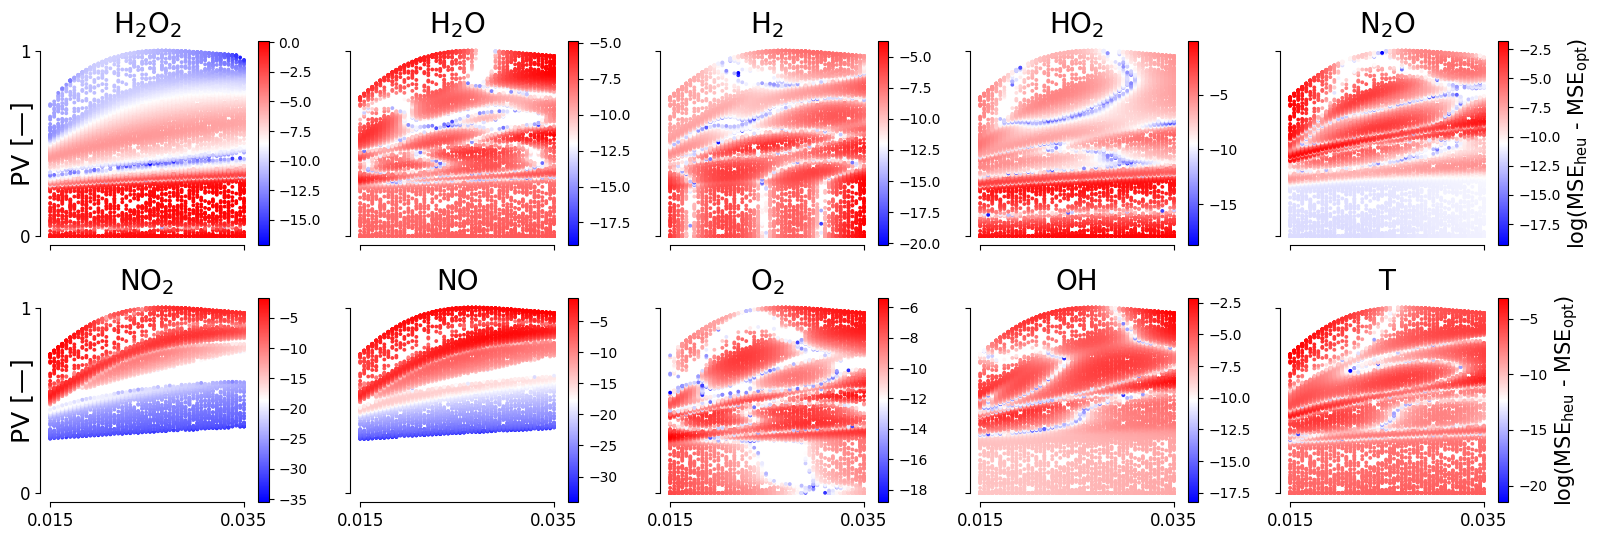

In [9]:
nbr_QoIs = 10  # QoIs 0 to 10

save = True
pathSave = "C:/Users/admin/Documents/PhD-ULB/Figures/2024-PV-optimization/Paper/EnergyAndAI/Supplementary-material/Source-error-MSE/Heuristic-vs-optimized/"
name = f"Source of MSE_NN error - heuristic vs optimized - error heurisitic - without PV source"

keys = ['H2O2', 'H2O', 'H2', 'HO2', 'N2O', 'NO2', 'NO', 'O2', 'OH', 'T', '$\dot{\omega}_{\mathrm{PV}}$']
keys = [k.replace("2", "$_2$") for k in keys]

# Create a figure with 3 rows x 4 columns (or adjust as you like)
rows = 2
cols = 5
fig, axes = plt.subplots(rows, cols, figsize=(16,5.5)) #16,11 for 4,3
axes = axes.flatten()  # flatten for easy indexing

for idxQoI in range(nbr_QoIs):
    
    ax = axes[idxQoI]  # current subplot
    
    y_min = PV_optimized_train_opt[seeds_heu].min()
    y_max = PV_optimized_train_opt[seeds_heu].max()

    # Scatter plot for this QoI
    sc = ax.scatter(
        mixture_fractions_train_0D[seeds_heu],
        (PV_optimized_train_opt[seeds_heu]-y_min)/(y_max - y_min),
        c=np.log(allObs_heu[:, idxQoI] - allObs_opt[:, idxQoI]),
        s=3,
        cmap='bwr'
    )
    
    ax.set_title(keys[idxQoI], fontsize = 20)
    ax.set_xticks([0.015, 0.035])
    if(idxQoI < nbr_QoIs - cols):
        ax.set_xticklabels([])
    ax.set_yticks([0, 1])
    if(idxQoI%cols != 0):
        ax.set_yticklabels([])
    ax.tick_params(axis = "both", labelsize = 12)
    ax.grid(False)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_bounds(0, 1)
    ax.spines["bottom"].set_bounds(0.015, 0.035)

    ax.set_ylim([-0.05, 1.05])

    cbar = fig.colorbar(sc, ax=ax, orientation='vertical', fraction=0.05, pad=0.02)
    if (idxQoI- cols + 1)%cols == 0:
        cbar.set_label("log(MSE$_{\mathrm{heu}}$ - MSE$_{\mathrm{opt}}$)", fontsize=15)
    cbar.ax.tick_params(labelsize=10)

    # Only label the y-axis on the first column
    if idxQoI % cols == 0:
        ax.set_ylabel("PV [—]", fontsize=18, labelpad = -10)

# Remove any unused subplots if 3x4 > 11
for ax in axes[nbr_QoIs:]:
    ax.axis('off')

plt.tight_layout()
if(save):
    plt.savefig(pathSave + name + ".png", dpi=1000, bbox_inches = "tight")
plt.show()

### Points where the full state-space model parametrized by the optimized PV makes larger prediction errors than the one parametrized by the heuristic PV

C:\Windows\Temp\ipykernel_29868\713525512.py:27: RuntimeWarning: invalid value encountered in log
  c=np.log(allObs_opt[:, idxQoI] - allObs_heu[:, idxQoI]),


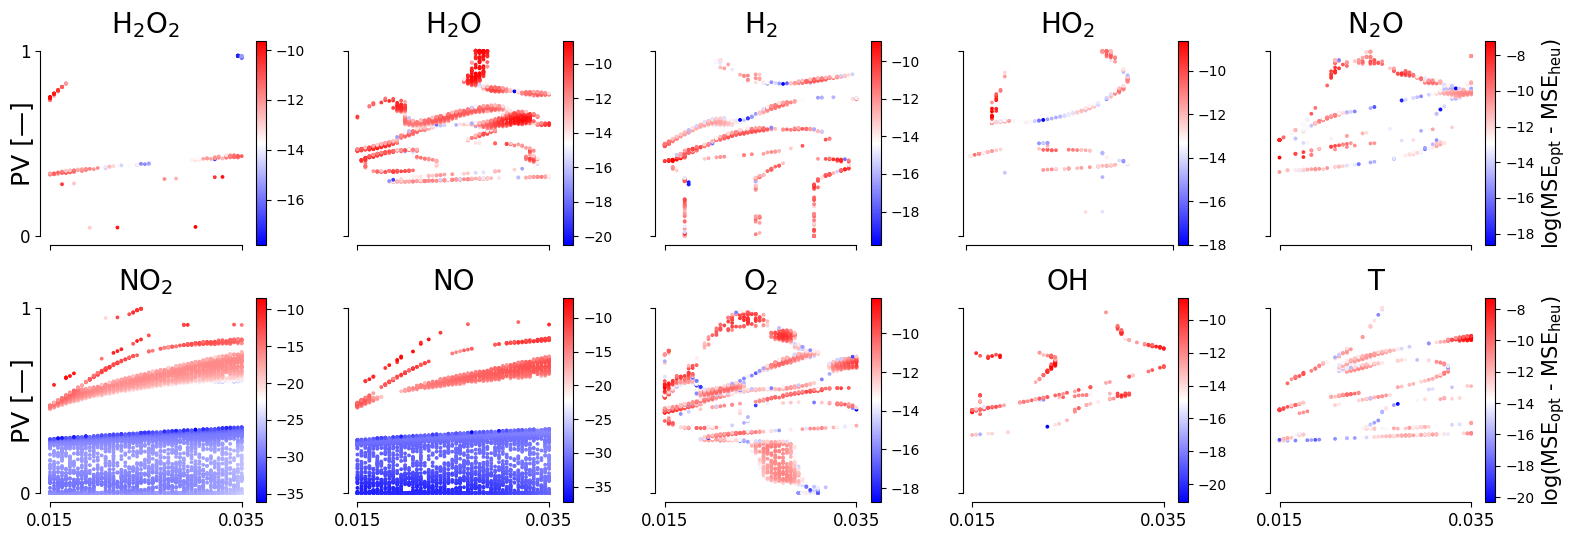

In [10]:
nbr_QoIs = 10  # QoIs 0 to 10

save = True
pathSave = "C:/Users/admin/Documents/PhD-ULB/Figures/2024-PV-optimization/Paper/EnergyAndAI/Supplementary-material/Source-error-MSE/Heuristic-vs-optimized/"
name = f"Source of MSE_NN error - heuristic vs optimized - error optimized - without PV source"

keys = ['H2O2', 'H2O', 'H2', 'HO2', 'N2O', 'NO2', 'NO', 'O2', 'OH', 'T', '$\dot{\omega}_{\mathrm{PV}}$']
keys = [k.replace("2", "$_2$") for k in keys]

# Create a figure with 3 rows x 4 columns (or adjust as you like)
rows = 2
cols = 5
fig, axes = plt.subplots(rows, cols, figsize=(16, 5.5))
axes = axes.flatten()  # flatten for easy indexing

for idxQoI in range(nbr_QoIs):
    
    ax = axes[idxQoI]  # current subplot
    
    y_min = PV_optimized_train_opt[seeds_heu].min()
    y_max = PV_optimized_train_opt[seeds_heu].max()

    # Scatter plot for this QoI
    sc = ax.scatter(
        mixture_fractions_train_0D[seeds_opt],
        (PV_optimized_train_opt[seeds_opt] - y_min)/(y_max - y_min),
        c=np.log(allObs_opt[:, idxQoI] - allObs_heu[:, idxQoI]),
        s=3,
        cmap='bwr'
    )
    
    ax.set_title(keys[idxQoI], fontsize = 20)
    ax.set_xticks([0.015, 0.035])
    if(idxQoI < nbr_QoIs - cols):
        ax.set_xticklabels([])
    ax.set_yticks([0, 1])
    if(idxQoI%cols != 0):
        ax.set_yticklabels([])
    ax.tick_params(axis = "both", labelsize = 12)
    ax.grid(False)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_bounds(0, 1)
    ax.spines["bottom"].set_bounds(0.015, 0.035)

    ax.set_ylim([-0.05, 1.05])

    cbar = fig.colorbar(sc, ax=ax, orientation='vertical', fraction=0.05, pad=0.02)
    if (idxQoI- cols + 1)%cols == 0:
        cbar.set_label("log(MSE$_{\mathrm{opt}}$ - MSE$_{\mathrm{heu}}$)", fontsize=15)
    cbar.ax.tick_params(labelsize=10)

    # Only label the y-axis on the first column
    if idxQoI % cols == 0:
        ax.set_ylabel("PV [—]", fontsize=18, labelpad = -10)

# Remove any unused subplots if 3x4 > 11
for ax in axes[nbr_QoIs:]:
    ax.axis('off')

plt.tight_layout()
if(save):
    plt.savefig(pathSave + name + ".png", dpi=1000, bbox_inches = "tight")
plt.show()

### The improvements are in the regions where it has been stretched out